# balanced turbulence overview

see link to [forcing description](../configs/itbalt/readme.ipynb)

In [1]:
from glob import glob

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
import xarray as xr

import xrft

import crocosi.postp as pp
import crocosi.gridop as op
import crocosi.plot as cplt

In [2]:
from dask.distributed import Client, LocalCluster
#
cluster = LocalCluster()
#
#from dask_jobqueue import PBSCluster
#cluster = PBSCluster()
#w = cluster.scale(jobs=2)
#
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:43251 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 107.37 GB


## Load data

In [4]:
root_path = '/home/datawork-lops-osi/equinox/itbalt/'
#root_path = '/home1/scratch/aponte/'
#root_path = '/home/c11-data/Test_aponte/fsturb/'

# uniform N
run = 'fsturb_m0_4km_0a1000j/'
#run = 'fsturb_m1_4km_0a1000j/'

# exponential stratification
run = 'fsturb_4km_m1_Nexp_0a1000j'

r = pp.Run(root_path+run, outputs=['surf', 'his'], verbose=1)
r['surf'] = r['surf'].assign_coords(time=r['surf'].time_instant.chunk({'time':None}))
r['his'] = r['his'].assign_coords(time=r['his'].time_counter.chunk({'time':None}))

pout = r.params_output

Analysing directory /home/c11-data/Test_aponte/fsturb/fsturb_4km_m1_Nexp_0a1000j
Found 10 segments
Parameters detected in croco.in :
  time step = 300.0 s
Parameters detected in output.mpi :
Opening datasets: grid / surf / his
Grid size: (L ,M, N) = (258, 722, 50)


In [16]:
for k, v in pout.items():
    print('{}: {}'.format(k,v))

tdiag_omega: 0.0001454441043
depth: 4000.0
f0: 0.00010313
beta: 0.0
yrbeta: 1440000.0
ini_flag: 1.0
ini_delta_rho: 0.001
ini_H_tcline: 0.15
ini_H_mld: 0.025
ini_H: 4000.0
fst_dt: 864000.0
fst_tdecay: 69120000.0
fst_Nmode: 5.0
fst_a: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
fst_xmid: 0.0
fst_xwid: 0.0
fst_ymid: 1440000.0
fst_ywid: 500000.0
fst_F: 0.001
fst_k: 1.5e-05
fst_dk: 5e-06
fst_Lmin: 50000.0
fst_Lmax: 100000.0


---

## utils

In [5]:
def plot_Fy(p, ax=None, scale=1, ls='--', color='k', **kwargs):
    #p = r.params_output
    ymid = p['fst_ymid']*scale
    ywid = p['fst_ywid']*scale
    if ax is not None:
        ax.axhline(ymid-ywid, ls=ls, color=color)
        ax.axhline(ymid+ywid, ls=ls, color=color)
    else:
        plt.axhline(ymid+ywid, ls=ls, color=color)
        plt.axhline(ymid-ywid, ls=ls, color=color)

---

## bulk statistics

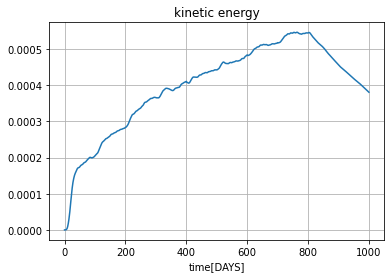

In [6]:
ax = r.stats['KINETIC_ENRG'].plot(title='kinetic energy')
ax.grid()

In [7]:
ds = r['surf']
ds['u2'] = ds.u**2
ds['v2'] = ds.v**2
ds_mean = ds.mean(dim=['x_rho','x_u','time']).persist()

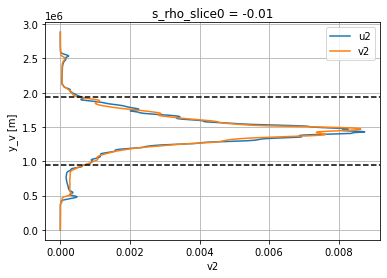

In [8]:
ax = plt.subplot(111)
ds_mean.u2.plot(y='y_rho', ax=ax, label='u2')
ds_mean.v2.plot(y='y_v', ax=ax, label='v2')
ax.legend()
ax.grid()
plot_Fy(pout)

In [9]:
u2_meanx = (r['surf'].u**2).mean(dim=['x_u']).persist()

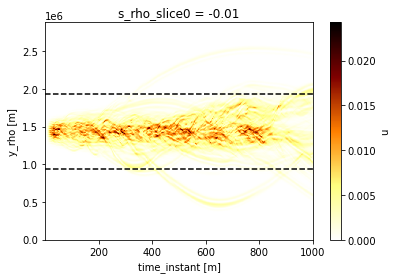

In [10]:
u2_meanx.plot(x='time', y='y_rho', cmap='afmhot_r') #.values.shape
plot_Fy(pout)

--- 

## pictures

### sea level

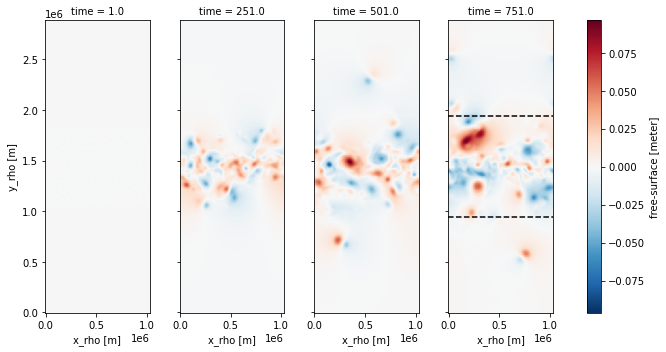

In [11]:
hdl = (r['surf']['ssh'].sel(time=slice(0,1000,250))
         .plot(x='x_rho', y='y_rho', col='time', col_wrap=4, 
               subplot_kws={'aspect':'equal'},
               aspect=.5, figsize=(10,5))
       )
plot_Fy(pout, ax=hdl.axes[0,-1])

### surface zonal velocity

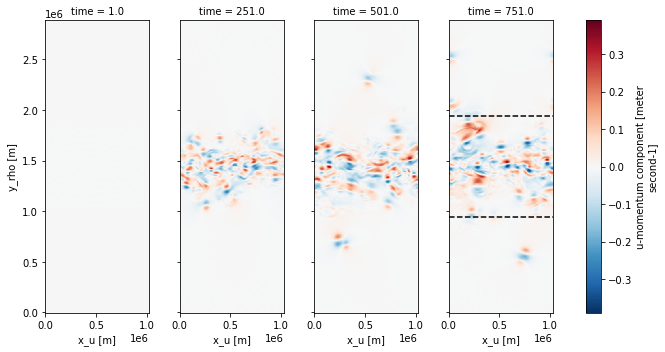

In [12]:
hdl = (r['surf']['u'].sel(time=slice(0,1000,250))
         .plot(x='x_u', y='y_rho', col='time', col_wrap=4, 
               subplot_kws={'aspect':'equal'},
               aspect=.5, figsize=(10,5))
)
plot_Fy(pout, ax=hdl.axes[0,-1])

### surface relative vorticity

In [13]:
u, v = r['surf']['u'], r['surf']['v']
zeta = (-r.xgrid.derivative(u, 'eta') + r.xgrid.derivative(v, 'xi'))

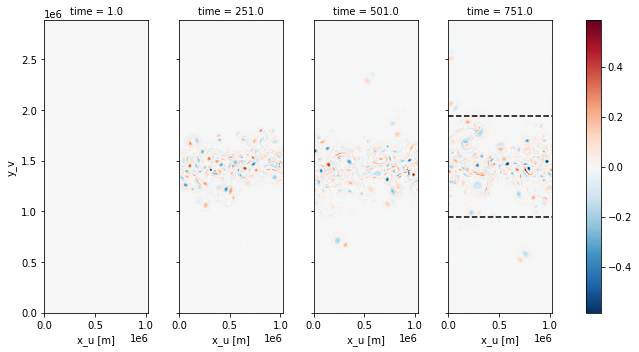

In [14]:
f_zeta = r.xgrid.interp(r.xgrid.interp(r['grid'].f, 'eta'), 'xi')
hdl = ((zeta/f_zeta).sel(time=slice(0,1000,250))
         .plot(x='x_u', y='y_v', col='time', col_wrap=4, 
               subplot_kws={'aspect':'equal'},
               aspect=.5, figsize=(10,5))
)
plot_Fy(pout, ax=hdl.axes[0,-1])

---

## vertical slices

In [17]:
z_u = r.get_z(zeta=r['his'].ssh_t_dirac, hgrid='u')
ds = r['his'].assign_coords(z_u = z_u)

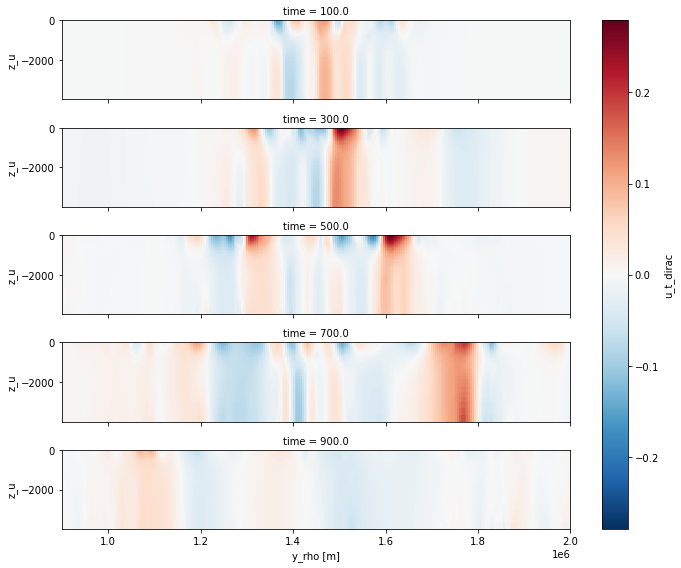

In [18]:
(ds.u_t_dirac
 .isel(x_u=0).sel(time=np.arange(100,1000,200), method='nearest')
 .plot(x='y_rho', y='z_u', 
       xlim=(900*1e3,2000*1e3),
       figsize=(10,8),
       col='time', col_wrap=1)
)

---

## vertical mode projections

In [ ]:
# load vmodes from croco outputfiles

#vmodes = vmd.Vmodes(r['xgrid'], 
#                    vmodes_croco.zr, vmodes_croco.zw, 
#                    vmodes_croco.N2, 
#                    vmodes_croco.mode.size, 
#                    persist=True)

---

## wavenumber spectra with xrft

In [19]:
u = r['surf']['u'].sel(time=slice(0,None,5))
v = r['surf']['v'].sel(time=slice(0,None,5))

In [20]:
uhat2 = xrft.power_spectrum(r.xgrid.interp(u,'xi', boundary='extend')
                            .chunk({'x_rho': None, 'y_rho': None}),
                            dim=['x_rho','y_rho'], 
                            detrend='constant', window=True).compute()
vhat2 = xrft.power_spectrum(r.xgrid.interp(v,'eta', boundary='extend')
                            .chunk({'x_rho': None, 'y_rho': None}),
                            dim=['x_rho','y_rho'], 
                            detrend='constant', window=True).compute()
ekehat = .5*(uhat2 + vhat2).mean('time').persist()

In [21]:
kx = (ekehat['freq_x_rho']*1e3).rename('kx [1/km]')
ky = (ekehat['freq_y_rho']*1e3).rename('ky [1/km]')

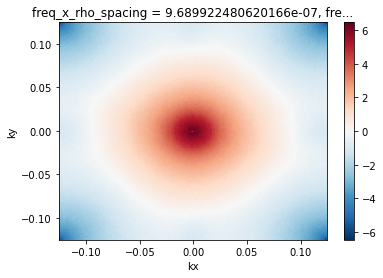

In [22]:
np.log10(ekehat.assign_coords(kx=kx, ky=ky)).plot(x='kx', y='ky') #, subplot_kws={'aspect':'equal'}, aspect=.5, figsize=(5,5))

In [23]:
ekehat_iso = xrft.isotropize(ekehat, ['freq_y_rho','freq_x_rho'])
ekehat_iso = ekehat_iso.assign_coords(k=ekehat_iso.freq_r*1e3)

In [24]:
def add_slope(k_start=None, k_end=None, level_start=None, slope=None):
    if isinstance(slope, list):
        [add_slope(k_start, k_end, level_start, ls) for ls in slope]
    else:
        k = np.arange(k_start,k_end,(k_end-k_start)/3.)
        y = level_start*(k/k[0])**slope
        plt.plot(k, y, 'k')
        plt.text(k[-1], y[-1], ' {i}'.format(i=slope))

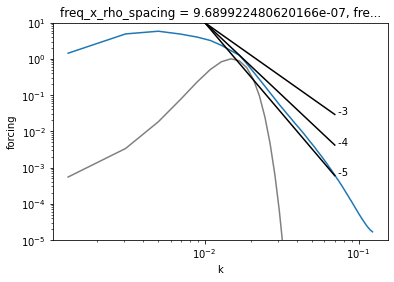

In [25]:
ekehat_iso.plot(x='k', xscale='log', yscale='log')

# get forcing wavenumbers
F_k = 1e3*r.params_output['fst_k']
F_dk = 1e3*r.params_output['fst_dk']
F = np.exp(-((ekehat_iso.k-F_k)/F_dk)**2).rename('forcing')

F.plot(x='k', xscale='log', yscale='log', 
                           ylim=(1e-5, 1e1), color='0.5')

add_slope(k_start=1e-2, k_end=1e-1, level_start=1e1, slope=[-3, -4, -5])

In [26]:
u = r['surf']['u'].sel(time=slice(50,1000,100))
v = r['surf']['v'].sel(time=slice(50,1000,100))
uhat2 = xrft.power_spectrum(r.xgrid.interp(u,'xi', boundary='extend')
                            .chunk({'x_rho': None, 'y_rho': None}),
                            dim=['x_rho','y_rho'], 
                            detrend='constant', 
                            window=True).compute()
vhat2 = xrft.power_spectrum(r.xgrid.interp(v,'eta', boundary='extend')
                            .chunk({'x_rho': None, 'y_rho': None}),
                            dim=['x_rho','y_rho'], 
                            detrend='constant', 
                            window=True).compute()
ekehat = .5*(uhat2 + vhat2)

ekehat_iso = xrft.isotropize(ekehat, ['freq_y_rho','freq_x_rho'])
ekehat_iso = ekehat_iso.assign_coords(k=ekehat_iso.freq_r*1e3)
ekehat_iso = ekehat_iso.persist()

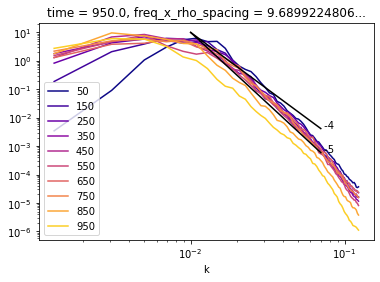

In [27]:
#hdl = ekehat_iso.plot(x='k', hue='time', xscale='log', yscale='log')
#
colors = cplt.get_cmap_colors(ekehat_iso.time.size)
for t, c in zip(ekehat_iso.time, colors):
    ekehat_iso.sel(time=t).plot(x='k', color=c,
                                xscale='log', yscale='log',
                                label='{t}'.format(t=int(t)))
plt.legend()
#add_slope(1e-2, 1e-1, 1e-2, [-4,-5])
add_slope(k_start=1e-2, k_end=1e-1, level_start=1e1, slope=[-4, -5])

---

## make movies

In [5]:
def atom(ax, da, ax_kwargs, test=None, **plt_kwargs):
    #
    xc = next((x for x in da.dims if x[0]=='x'), False)
    yc = next((x for x in da.dims if x[0]=='y'), False)
    da = da.assign_coords(x=da[xc]/1e3, y=da[yc]/1e3)
    #
    d = int(da.time)
    title = da.name+' day = %d'%(d)
    #h = (_da.time-d)*24
    #title = da.name+' day = %d / h = %.2f hour '%(d, h)
    #
    da.plot(x='x',y='y', ax=ax, **plt_kwargs)
    plot_Fy(pout, ax=ax, scale=1e-3)
    ax.set_aspect('equal', 'box')
    ax.set(**ax_kwargs)
    ax.set_title(title)

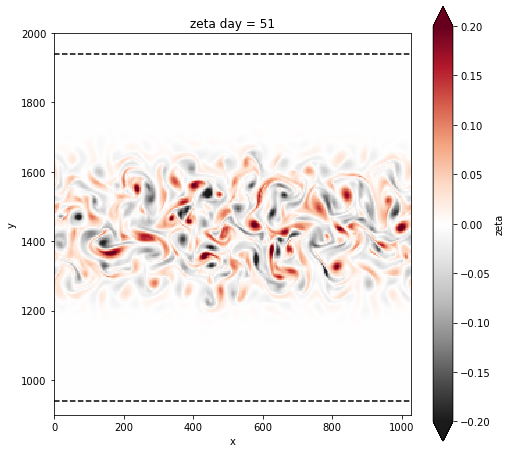

In [6]:
u, v = r['surf']['u'], r['surf']['v']

zeta = (-r.xgrid.derivative(u, 'eta') + r.xgrid.derivative(v, 'xi'))
f_zeta = r.xgrid.interp(r.xgrid.interp(r['grid'].f, 'eta'), 'xi')
da = (zeta/f_zeta).rename('zeta').isel(time=slice(0,None,1))
plt_kw = {'vmin': -.2, 'vmax': .2, 'cmap': 'RdGy_r', 
          'extend':'both'}
ax_kw = {'ylim': (900, 2000)}
cplt.movie_figure(atom, da, i=50, test=True, figsize=(8,8), 
             ax_kwargs=ax_kw, **plt_kw)

In [7]:
cplt.movie_wrapper(atom, client, da,
                   figsize=(8,8),
                   ax_kwargs=ax_kw, 
                   **plt_kw)
# for some reason, breaks if on a local (1 node) cluster
# with typical matplotlib thread issue:
# https://github.com/pydata/xarray/issues/1889

125 batches to be done
 batch 0-7
 batch 8-15
 batch 16-23
 batch 24-31
 batch 32-39
 batch 40-47
 batch 48-55
 batch 56-63
 batch 64-71
 batch 72-79
 batch 80-87
 batch 88-95
 batch 96-103
 batch 104-111
 batch 112-119
 batch 120-127
 batch 128-135
 batch 136-143
 batch 144-151
 batch 152-159
 batch 160-167
 batch 168-175
 batch 176-183
 batch 184-191
 batch 192-199
 batch 200-207
 batch 208-215
 batch 216-223
 batch 224-231
 batch 232-239
 batch 240-247
 batch 248-255
 batch 256-263
 batch 264-271
 batch 272-279
 batch 280-287
 batch 288-295
 batch 296-303
 batch 304-311
 batch 312-319
 batch 320-327
 batch 328-335
 batch 336-343
 batch 344-351
 batch 352-359
 batch 360-367
 batch 368-375
 batch 376-383
 batch 384-391
 batch 392-399
 batch 400-407
 batch 408-415
 batch 416-423
 batch 424-431
 batch 432-439
 batch 440-447
 batch 448-455
 batch 456-463
 batch 464-471
 batch 472-479
 batch 480-487
 batch 488-495
 batch 496-503
 batch 504-511
 batch 512-519
 batch 520-527
 batch 528-535


---

In [8]:
cluster.close()